In [1]:
#==================================================
# Imports
#==================================================
import numpy as np
import matplotlib.pyplot as plt
import glob
import xarray
import datetime
import calendar
import matplotlib
import os
#import h5py
import PseudoNetCDF as pnc
from scipy.ndimage import label
import scipy.interpolate as interp
import pickle
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import matplotlib.colors as mcolors
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import h5py
from matplotlib.patches import Rectangle
from scipy.integrate import cumulative_trapezoid as scitrapz

In [2]:
def toTimestamp(d):
    return calendar.timegm(d.timetuple())

# Read in Learjet data (bulk microphysics, state variables, and FFSSP probe), all publicly availble on the CAMP2Ex data portal (https://www-air.larc.nasa.gov/cgi-bin/ArcView/camp2ex)

In [3]:
path = '/discover/nobackup/mwstanfo/camp2ex_data/learjet/20190925/'
file_bulk_props = path+'CAMP2Ex-CloudBulkProps_Learjet_20190925_R0.ICT'
file_ffssp = path+'CAMP2Ex-FFSSP_Learjet_20190925_R0.ict'
file_state = path+'CAMP2Ex-Page0_Learjet_20190925_R0.ict'

In [4]:
start_date = datetime.datetime(2019,9,25)
twc_thresh = 1.e-1

In [5]:
def process_state_bulk(state_file_name,bulk_file_name,start_date):
    """
    Processes the Bulk and State files from the Learjet flight.
    """
    
    #===========================================
    # State file
    #===========================================

    infile = pnc.pncopen(state_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out state properties
    tas = var_list['TAS'].data # True air speed (m/s)
    pres_alt = var_list['Palt'].data # Pressure altitude (ft)
    temp = var_list['Temp'].data # temperature (C)
    dew = var_list['Dew'].data # dewpoint temperature (C)
    NevLWC = var_list['NevLWC'].data # Nevzorov LWC (g/m3)
    FSSPWC = var_list['FSSPWC'].data # FFSSP water content (g/m3)
    FCDPHWC = var_list['FCDPHWC'].data # Hawkeye-FCDP water content (g/m3)
    FCDPWC = var_list['FCDPWC'].data # FCDP water content (g/m3)
    NevTWC = var_list['NevTWC'].data # Nevzorov total water content (g/m3)
    VaV = var_list['VaV'].data # Vertical wind (updraft) (m/s)
    FSSPconc = var_list['FSSPConc'].data # FFSSP concentration (#/cc)
    FCDPHconc = var_list['FCDPHConc'].data # Hawkeye-FCDP concentration (#/cc)
    FCDPconc = var_list['FCDPConc'].data # FCDP concentration (#/cc)
    x2DSHsn10 = var_list['2DSHsn10'].data # SPEC 2D-S SN10 Concentration, H-channel (#/L)
    x2DSVsn10 = var_list['2DSVsn10'].data # SPEC 2D-S SN10 Concentration, V-channel (#/L)
    x2DSHNcar = var_list['2DSHNcar'].data # NCAR 2D-S Concentration, H-channel (#/L)
    x2DSVNcar = var_list['2DSVNcar'].data # NCAR 2D-S Concentration, V-channel (#/L)
    x2DS10Hawk = var_list['2DS10Hawk'].data # Hawkeye-2DS 10um channel concentration (#/L)
    x2DS50Hawk = var_list['2DS50Hawk'].data # Hawkeye-2DS 50um channel concentration (#/L)
    HVPS = var_list['HVPS'].data # HVPS concentration (#/L)
    CPC = var_list['CPC'].data # CPC concentration (#/cc)
    PCASP = var_list['PCASP'].data # PCASP concentration (#/cc)
    lat = var_list['Lat'].data
    lon = var_list['Long'].data
    rice = var_list['Rice'].data
    
    state_dict = {'pres_alt':pres_alt,\
                'temp':temp,\
                'dew':dew,\
                'tas':tas,\
                'alt':pres_alt*0.3048*1.e-3,\
                'NevLWC':NevLWC,\
                'FSSPWC':FSSPWC,\
                'FCDPHWC':FCDPHWC,\
                'FCDPWC':FCDPWC,\
                'NevTWC':NevTWC,\
                'VaV':VaV,\
                'FSSPconc':FSSPconc,\
                'FCDPHconc':FCDPHconc,\
                'FCDPconc':FCDPconc,\
                '2DSHsn10':x2DSHsn10,\
                '2DSVsn10':x2DSVsn10,\
                '2DSHNcar':x2DSHNcar,\
                '2DSVNcar':x2DSVNcar,\
                '2DS10Hawk':x2DS10Hawk,\
                '2DS50Hawk':x2DS50Hawk,\
                'HVPS':HVPS,\
                'CPC':CPC,\
                'PCASP':PCASP,\
                'time':time,\
                'lat':lat,\
                'lon':lon,\
                'rice':rice,\
               }
    
    
    #===========================================
    # Bulk Props File
    #===========================================    
    infile = pnc.pncopen(bulk_file_name, format = 'ffi1001')
    var_list = infile.variables
    keys = list(var_list.keys())

    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])

    cp_type = var_list['CP_Type'].data # (#), none, Cloud pass type, 1 = "Cloud" High Concentration of small particles (WC>0.1g/m3 for scatter probes in 1-50um range), 2 = "Precip" High Concentration of HVPS Particles (N>100/s), 3 = "Scud" Cloud Flag >0
    conc_L = var_list['Concentration_L'] #  (#/L), CldMicro_NumSizeDist_InSitu_Imaging_DroptoPrecip_AMB, Cloud-averaged composite total particle concentration from interpolated concentration PSD(1um-10mm)
    iwc = var_list['IWC_gm3'].data # (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB,  Cloud-averaged composite Ice water content (all particles treated as Ice) from interpolated concentration PSD (1um-10mm) using Brown and Francis 1995 method
    lwc = var_list['LWC_gm3'].data #  (g/m3), CldMicro_TWC_InSitu_None_Bulk_AMB, Cloud-averaged composite Liquid water content (all particles treated as liquid Rho = 1kg/L) from interpolated concentration PSD (1um-10mm) assuming all spherical particles
    reff = var_list['Reff_um'].data # (um),   CldMicro_MeanSize_InSitu_Imaging_DroptoPrecip_None, Cloud-averaged composite Effective Radius from interpolated concentration PSD (1um-10mm)
    ze = var_list['Z_dBz'].data # (dBz),  none, Cloud-averaged composite (Estimated) Radar Reflectivity from interpolated concentration PSD (1um-10mm)    
    
    
    bulk_dict = {'time':time,\
                 'lat':lat,\
                 'lon':lon,\
                 'cp_type':cp_type,\
                 'conc_L':conc_L,\
                 'iwc':iwc,\
                 'lwc':lwc,\
                 'reff':reff,\
                 'ze':ze}
        
    return state_dict,bulk_dict

# Create dictionaries holding bulk microphysical and state variable data from Learjet

In [6]:
state_dict,bulk_dict = process_state_bulk(file_state,file_bulk_props,start_date)

# Function to process FFSSP data and put in dictionary

In [7]:
def process_ffssp(file_name,start_date):
    infile_ffssp = pnc.pncopen(file_name, format = 'ffi1001')
    var_list = infile_ffssp.variables
    keys = list(var_list.keys())
    #print(var_list)
    
    # Make Datetime arrays
    secs_from_00z = var_list['Time_Start'].data
    nt = len(secs_from_00z)
    time = np.array([start_date + datetime.timedelta(seconds=secs_from_00z[dd]) for dd in range(nt)])
    
    # Pull out bulk properties
    twc = var_list['twc'].data
    conc = var_list['conc'].data
    ext = var_list['ext'].data
    cnt = var_list['CNT'].data
    sv = var_list['sv'].data

        
    # Make a dictionary that holds the concentrations for each bin
    cbin_dict = {}
    for key in keys:
        if 'cbin' in key:
            cbin_dict[key] = var_list[key].data
            
    # Make a dictionary that holds the raw counts for each bin
    nbin_dict = {}
    for key in keys:
        if 'nbin' in key:
            nbin_dict[key] = var_list[key].data                
            
    sizes = [0,1.5,3,4.5,6,8,10,12,14,16,18,21,24,27,30,33,36,39,42,46,50]
    mid_sizes = np.array([0.5*(sizes[dd] + sizes[dd+1]) for dd in range(len(sizes)-1)])
            
    var_dict = {'twc':twc,\
                'conc':conc,\
                'ext':ext,\
                'cbin_dict':cbin_dict,\
               'time':time,\
               'sizes':sizes,\
               'mid_sizes':mid_sizes}
        
    return var_dict


# Return FFSSP dictionary and process data further to calculate effective radius and effective variance

In [9]:
ffssp_dict = process_ffssp(file_ffssp,start_date)

state_alt = state_dict['alt']
state_time = state_dict['time']


ffssp_cbin_dict = ffssp_dict['cbin_dict']
ffssp_cloud_id = np.where(ffssp_dict['twc'] >= twc_thresh)[0]
ffssp_time = ffssp_dict['time'][ffssp_cloud_id]

ffssp_alt = []

for ii in range(len(ffssp_time)):
    dumid = np.where(state_time == ffssp_time[ii])[0]
    ffssp_alt.append(state_alt[dumid[0]])
ffssp_alt = np.array(ffssp_alt)


for key,val in ffssp_cbin_dict.items():
    ffssp_cbin_dict[key] = val[ffssp_cloud_id]
ffssp_dict['twc'] = ffssp_dict['twc'][ffssp_cloud_id]
ffssp_dict['ext'] = ffssp_dict['ext'][ffssp_cloud_id]
ffssp_dict['conc'] = ffssp_dict['conc'][ffssp_cloud_id]
ffssp_dict['time'] = ffssp_time
ffssp_dict['alt'] = ffssp_alt
    
ffssp_dsd = []

for ii in range(len(ffssp_cloud_id)):
    dum_arr = []
    for key in ffssp_cbin_dict.keys():
        dum_arr.append(ffssp_cbin_dict[key][ii])
    dum_arr = np.array(dum_arr)
    ffssp_dsd.append(dum_arr)
ffssp_dsd = np.array(ffssp_dsd)   

ffssp_sizes = ffssp_dict['sizes']
ffssp_mid_sizes = ffssp_dict['mid_sizes']
size_diff = np.diff(ffssp_sizes)
rad_size_diff = size_diff/2.


ffssp_reff = []
ffssp_veff = []
ffssp_veff_cumu = []

for ii in range(len(ffssp_cloud_id)):
    dum_dsd = ffssp_dsd[ii,:] # #/m3/um
    #r3 = np.trapezoid(dum_dsd[0:-1]*size_diff/rad_size_diff*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.)
    #r2 = np.trapezoid(dum_dsd[0:-1]*size_diff/rad_size_diff*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.)
    r4 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**4.),ffssp_mid_sizes/2.)
    r3 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.)
    r2 = np.trapezoid(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.)
    #reff_num_cumu = scitrapz(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**3.),ffssp_mid_sizes/2.,initial=0)
    #reff_den_cumu = scitrapz(dum_dsd[0:-1]*((ffssp_mid_sizes/2.)**2.),ffssp_mid_sizes/2.,initial=0)
    
    reff = r3/r2 # um
    #tmp_reff_cumu = reff_num_cumu/reff_den_cumu # um
    #tmp_reff = tmp_reff*1.e-6 # m
    #tmp_reff_cumu = tmp_reff_cumu*1.e-6
    #tmp_reff_cumu[np.isnan(tmp_reff_cumu)] = 0.
    tmp_ffssp_mid_sizes = ffssp_mid_sizes*1.e-6/2. # m in radius
    #tmp_dum_dsd = dum_dsd[0:-1]*size_diff/rad_size_diff*1.e6 # #/m4 normalized by radius width instead of diameter width
    #eff_num = np.trapezoid(tmp_dum_dsd*np.pi*(tmp_ffssp_mid_sizes**2.)*(tmp_ffssp_mid_sizes - tmp_reff)**2.,tmp_ffssp_mid_sizes)
    #veff_den = np.trapezoid(tmp_dum_dsd*np.pi*(tmp_ffssp_mid_sizes**2.),tmp_ffssp_mid_sizes)*(tmp_reff**2.)

    #veff_num_cumu = scitrapz(tmp_dum_dsd*np.pi*(tmp_ffssp_mid_sizes**2.)*(tmp_ffssp_mid_sizes - tmp_reff_cumu)**2.,tmp_ffssp_mid_sizes,initial=0)
    #veff_den_cumu = scitrapz(tmp_dum_dsd*np.pi*(tmp_ffssp_mid_sizes**2.),tmp_ffssp_mid_sizes,initial=0)*(tmp_reff_cumu**2.)
    veff = (r2*r4)/(r3**2.)-1.
    
    #print(veff_num/veff_den)
    ffssp_reff.append(reff)
    ffssp_veff.append(veff)
    #ffssp_veff_cumu.append((veff_num_cumu/veff_den_cumu)[-1])

    
ffssp_reff = np.array(ffssp_reff)
ffssp_veff = np.array(ffssp_veff)
ffssp_veff_cumu = np.array(ffssp_veff_cumu)
ffssp_dict['reff'] = ffssp_reff
ffssp_dict['veff'] = ffssp_veff
#ffssp_dict['veff_cumu'] = ffssp_veff_cumu


# Read in RSP files, also publicly availble on the CAMP2Ex data portal, and calculate percentiles of Nd and Reff for height bins

In [10]:
# RSP files
path = '/discover/nobackup/mwstanfo/camp2ex_data/rsp/20190925/v2/'
base_time = datetime.datetime(2019,9,25)

files = sorted(glob.glob(path+'*.h5'))
num_files = len(files)
print('# of RSP files:',num_files)

infile = h5py.File(files[0],"r")
keys_list = list(infile.keys())
data = infile['Data']

time_arr = []
cth_arr = []
ctt_arr = []
Reff_arr = []
ve_arr = []
tau_arr = []
phase_arr = []
nd_arr = []
lwp_arr = []
cloud_test_arr = []


for tt in range(num_files):
    
    file_name = files[tt]
    file_time = file_name.split('/')[-1]
    file_time = file_time.split('.')[0]
    file_time = file_time.split('_')[-2]
    

    infile = h5py.File(file_name,"r")
    keys_list = list(infile.keys())
    data = infile['Data']
    geom = infile['Geometry']
    time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
    # Convert to datetimes
    time = np.array([base_time + datetime.timedelta(seconds=time_secs[dd]) for dd in range(len(time_secs))])
    #alt = np.array(geom['Collocated_Altitude'])
    cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
    cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
    cloud_top_temp = np.array(data['Cloud_Top_Temperature'])
    #print(np.shape(cloud_top_temp))
    cloud_liquid_index = np.array(data['Cloud_Liquid_Index'])[:,0]
    #print(np.shape(cloud_liquid_index))
    #print(aaaa)
    cloud_bow_optical_thickness = np.array(data['Cloud_Bow_Optical_Thickness'])
    cloud_bow_droplet_effective_radius = np.array(data['Cloud_Bow_Droplet_Effective_Radius'])
    cloud_bow_droplet_effective_variance = np.array(data['Cloud_Bow_Droplet_Effective_Variance'])
    cloud_bow_droplet_number_concentration_adiabatic = np.array(data['Cloud_Bow_Droplet_Number_Concentration_Adiabatic'])
    cloud_bow_liquid_water_path = np.array(data['Cloud_Bow_Liquid_Water_Path'])
    
    time_arr.append(time)
    cth_arr.append(cloud_top_alt)
    Reff_arr.append(cloud_bow_droplet_effective_radius)
    ve_arr.append(cloud_bow_droplet_effective_variance)
    tau_arr.append(cloud_bow_optical_thickness)
    phase_arr.append(cloud_liquid_index)
    cloud_test_arr.append(cloud_test_passed)
    nd_arr.append(cloud_bow_droplet_number_concentration_adiabatic)
    lwp_arr.append(cloud_bow_liquid_water_path)
    ctt_arr.append(cloud_top_temp)
    
time_arr = np.array(time_arr,dtype=object)
cth_arr = np.array(cth_arr,dtype=object)
ctt_arr = np.array(ctt_arr,dtype=object)
Reff_arr = np.array(Reff_arr,dtype=object)
ve_arr = np.array(ve_arr,dtype=object)
tau_arr = np.array(tau_arr,dtype=object)
phase_arr = np.array(phase_arr,dtype=object)
cloud_test_arr = np.array(cloud_test_arr,dtype=object)
nd_arr = np.array(nd_arr,dtype=object)
lwp_arr = np.array(lwp_arr,dtype=object)

time_arr = np.concatenate(time_arr,axis=0)
cth_arr = np.concatenate(cth_arr,axis=0)
ctt_arr = np.concatenate(ctt_arr,axis=0)
tau_arr = np.concatenate(tau_arr,axis=0)
Reff_arr = np.concatenate(Reff_arr,axis=0)
ve_arr = np.concatenate(ve_arr,axis=0)
phase_arr = np.concatenate(phase_arr,axis=0)
cloud_test_arr = np.concatenate(cloud_test_arr,axis=0)
nd_arr = np.concatenate(nd_arr,axis=0)
lwp_arr = np.concatenate(lwp_arr,axis=0)



var_dict = {'time':time_arr,\
            'cth':cth_arr,\
            'ctt':ctt_arr,\
            'Reff':Reff_arr,\
            'v_e':ve_arr,\
            'tau':tau_arr,\
            'phase':phase_arr,\
            'nd':nd_arr,\
            'lwp':lwp_arr,\
            'cloud_test':cloud_test_arr}

if True:
    dumid = np.where((var_dict['nd'] > -999.) & (var_dict['cth'] > 0.))# & (var_dict['phase'] <= 0.3) )[0]
    #dumid = np.where((var_dict['nd'] > -999.) & (var_dict['cth'] > 0.) & (var_dict['tau'] > 1.) )[0]
    for key,val in var_dict.items():
        var_dict[key] = val[dumid]

        
        
        
tmp_keys = ['cth','Reff','v_e','tau','nd','lwp','ctt']
tmp_keys2 = ['mean','25','50','75','10','90','5','95']

rsp_ct_perc_dict = {}
for tmp_key in tmp_keys:
    rsp_ct_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = []

cth = var_dict['cth']*1.e-3
tau = var_dict['tau']
height_bins = np.arange(0,8000,1000)*1.e-3
#height_bins = np.arange(0,7500,500)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

samp_size_vert = []

cth_filter_arr = []
nd_filter_arr = []
Reff_filter_arr = []
v_e_filter_arr = []
rsp_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) )
    #dumid = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]) & (tau > 10.) )
    dumfrac = np.size(dumid)/np.size(cth)
    samp_size_vert.append(np.size(dumid))
    if np.size(dumid) > 10.:
        rsp_samp_size = rsp_samp_size + np.size(dumid)
        
    for tmp_key in tmp_keys:
        #print(tmp_key)
        #if dumfrac < 0.001:
        if np.size(dumid) < 10:
            for tmp_key2 in tmp_keys2:
                if tmp_key != 'ctt':
                    rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                else:
                    if tmp_key2 == 'mean':
                        if np.size(dumid) > 0.:
                            rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.mean(var_dict[tmp_key][dumid]))
                        elif np.size(dumid) == 0.:
                            dumid2 = np.where( (cth >= height_bins[kk]) & (cth < height_bins[kk+1]))
                            rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.mean(var_dict[tmp_key][dumid2]))
                    else:
                        rsp_ct_perc_dict[tmp_key][tmp_key2].append(np.nan)
                    
            continue
        else:
            rsp_ct_perc_dict[tmp_key]['mean'].append(np.mean(var_dict[tmp_key][dumid]))
            rsp_ct_perc_dict[tmp_key]['25'].append(np.percentile(var_dict[tmp_key][dumid],25))
            rsp_ct_perc_dict[tmp_key]['50'].append(np.percentile(var_dict[tmp_key][dumid],50))
            rsp_ct_perc_dict[tmp_key]['75'].append(np.percentile(var_dict[tmp_key][dumid],75))
            rsp_ct_perc_dict[tmp_key]['90'].append(np.percentile(var_dict[tmp_key][dumid],90))
            rsp_ct_perc_dict[tmp_key]['10'].append(np.percentile(var_dict[tmp_key][dumid],10))
            rsp_ct_perc_dict[tmp_key]['95'].append(np.percentile(var_dict[tmp_key][dumid],95))
            rsp_ct_perc_dict[tmp_key]['5'].append(np.percentile(var_dict[tmp_key][dumid],5))
            if tmp_key == 'nd':
                nd_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'Reff':
                Reff_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'cth':
                cth_filter_arr.append(var_dict[tmp_key][dumid])
            if tmp_key == 'v_e':
                v_e_filter_arr.append(var_dict[tmp_key][dumid])

for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        rsp_ct_perc_dict[tmp_key][tmp_key2] = np.array(rsp_ct_perc_dict[tmp_key][tmp_key2])


rsp_ctt_mean = rsp_ct_perc_dict['ctt']['mean']-273.15


# Linearly interpolate ctt_mean to height_bins

rsp_ctt_mean_interp = np.interp(height_bins,height_midbins,rsp_ctt_mean)
rsp_qn_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['nd']['mean'])
rsp_reff_l_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['Reff']['mean'])
rsp_v_e_l_mean_interp = np.interp(height_bins,height_midbins,rsp_ct_perc_dict['v_e']['mean'])

nd_filter_arr = np.concatenate(nd_filter_arr)
Reff_filter_arr = np.concatenate(Reff_filter_arr)
cth_filter_arr = np.concatenate(cth_filter_arr)
v_e_filter_arr = np.concatenate(v_e_filter_arr)


# of RSP files: 27


/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_41560/2199792493.py:37: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  time_secs = np.array(data['Product_Time_Seconds'])# seconds after midnight
/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_41560/2199792493.py:41: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cloud_test_passed = np.squeeze(np.array(data['Cloud_Test_Passed']))
/gpfsm/dnb33/tdirs/batch/slurm.42931965.mwstanfo/ipykernel_41560/2199792493.py:42: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments.
  cloud_top_alt = np.array(data['Cloud_Top_Altitude'])[0,:]
/gpfsm/dnb33/tdirs/batch/slurm.429319

# Calculate in situ percentiles of Nd and Reff for height bins

In [11]:
#======================================================
# Calculate percentages for FFSSP
#======================================================

tmp_keys = ['alt','conc','reff','veff']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

ffssp_perc_dict = {}
for tmp_key in tmp_keys:
    ffssp_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        ffssp_perc_dict[tmp_key][tmp_key2] = []

alt = ffssp_dict['alt']


height_bins = np.arange(0,8000,1000)*1.e-3
#height_bins = np.arange(0,7500,500)*1.e-3
#height_bins = np.arange(500,8500,1000)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

samp_size_vert = []
ffssp_samp_size = 0.
for kk in range(len(height_bins)-1):
    dumid = np.where( (alt >= height_bins[kk]) & (alt < height_bins[kk+1]) )
    dumfrac = np.size(dumid)/np.size(alt)
    samp_size_vert.append(np.size(dumid))
    if np.size(dumid) > 0.:
        ffssp_samp_size = ffssp_samp_size + np.size(dumid)
    for tmp_key in tmp_keys:
        #if dumfrac < 0.001:
        if np.size(dumid) <= 0.:
            for tmp_key2 in tmp_keys2:
                if tmp_key2 == 'mean':
                    ffssp_perc_dict[tmp_key][tmp_key2].append(np.mean(ffssp_dict[tmp_key][dumid]))
                else:
                    ffssp_perc_dict[tmp_key][tmp_key2].append(np.nan)          
            continue
        else:
            ffssp_perc_dict[tmp_key]['mean'].append(np.mean(ffssp_dict[tmp_key][dumid]))
            ffssp_perc_dict[tmp_key]['25'].append(np.percentile(ffssp_dict[tmp_key][dumid],25))
            ffssp_perc_dict[tmp_key]['50'].append(np.percentile(ffssp_dict[tmp_key][dumid],50))
            ffssp_perc_dict[tmp_key]['75'].append(np.percentile(ffssp_dict[tmp_key][dumid],75))
            ffssp_perc_dict[tmp_key]['90'].append(np.percentile(ffssp_dict[tmp_key][dumid],90))
            ffssp_perc_dict[tmp_key]['10'].append(np.percentile(ffssp_dict[tmp_key][dumid],10))
            ffssp_perc_dict[tmp_key]['95'].append(np.percentile(ffssp_dict[tmp_key][dumid],95))
            ffssp_perc_dict[tmp_key]['5'].append(np.percentile(ffssp_dict[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        ffssp_perc_dict[tmp_key][tmp_key2] = np.array(ffssp_perc_dict[tmp_key][tmp_key2])




# Calculate in situ percentile profiles of Nevzorov LWC

In [12]:
tmp_keys = ['alt','NevLWC','FSSPWC','NevTWC']
tmp_keys2 = ['mean','5','10','25','50','75','90','95']

state_perc_dict = {}
for tmp_key in tmp_keys:
    state_perc_dict[tmp_key] = {}
    for tmp_key2 in tmp_keys2:
        state_perc_dict[tmp_key][tmp_key2] = []

alt = state_dict['alt']
min_thresh = 0.1 # g/m3

height_bins = np.arange(0,8000,1000)*1.e-3
#height_bins = np.arange(0,7500,500)*1.e-3
height_midbins = np.array([(height_bins[dd]+height_bins[dd+1])/2. for dd in range(len(height_bins)-1)])

state_samp_size_vert = {'NevLWC':[],'FSSPWC':[],'NevTWC':[]}
for kk in range(len(height_bins)-1):
    for tmp_key in tmp_keys:
        dumid = np.where( (alt >= height_bins[kk]) & (alt < height_bins[kk+1]) & (state_dict[tmp_key] >= min_thresh) )
        
        if tmp_key != 'alt':
            state_samp_size_vert[tmp_key].append(np.size(dumid))
        if np.size(dumid) < 10.:
            for tmp_key2 in tmp_keys2:
                if tmp_key2 == 'mean':
                    state_perc_dict[tmp_key][tmp_key2].append(np.mean(state_dict[tmp_key][dumid]))
                else:
                    state_perc_dict[tmp_key][tmp_key2].append(np.nan)          
            continue
        else:
            state_perc_dict[tmp_key]['mean'].append(np.mean(state_dict[tmp_key][dumid]))
            state_perc_dict[tmp_key]['25'].append(np.percentile(state_dict[tmp_key][dumid],25))
            state_perc_dict[tmp_key]['50'].append(np.percentile(state_dict[tmp_key][dumid],50))
            state_perc_dict[tmp_key]['75'].append(np.percentile(state_dict[tmp_key][dumid],75))
            state_perc_dict[tmp_key]['90'].append(np.percentile(state_dict[tmp_key][dumid],90))
            state_perc_dict[tmp_key]['10'].append(np.percentile(state_dict[tmp_key][dumid],10))
            state_perc_dict[tmp_key]['95'].append(np.percentile(state_dict[tmp_key][dumid],95))
            state_perc_dict[tmp_key]['5'].append(np.percentile(state_dict[tmp_key][dumid],5))
    


for tmp_key in tmp_keys:
    for tmp_key2 in tmp_keys2:
        state_perc_dict[tmp_key][tmp_key2] = np.array(state_perc_dict[tmp_key][tmp_key2])




# Make some functions to help create legend for following plot

In [13]:
from matplotlib.collections import PatchCollection

# define an object that will be used by the legend
class MulticolorPatch(object):
    def __init__(self, colors,edgecolor):
        self.colors = colors
        self.edgecolor = edgecolor
        
# define a handler for the MulticolorPatch object
class MulticolorPatchHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        width, height = handlebox.width, handlebox.height
        patches = []
        for i, c in enumerate(orig_handle.colors):
            patches.append(plt.Rectangle([width/len(orig_handle.colors) * i - handlebox.xdescent, 
                                          -handlebox.ydescent],
                           width / len(orig_handle.colors),
                           height, 
                           facecolor=c, 
                           edgecolor=orig_handle.edgecolor))

        patch = PatchCollection(patches,match_original=True)

        handlebox.add_artist(patch)
        return patch

# Plot distributions for height bins of Reff, Veff, and Nd for RSP and FFSSP (Fig. 5 of manuscript)

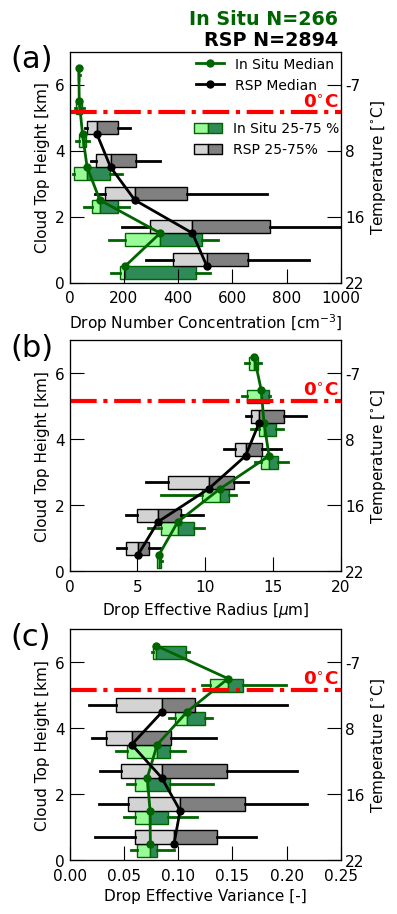

done


In [21]:
fig = plt.figure(figsize=(3.5,10.5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
Fontsize=11
axlist = [ax1,ax2,ax3]
#ax1.grid(lw=1,c='dimgrey',ls='dotted')
for ax in axlist:
    ax.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize,direction='in',which='both',length=10)
    ax.set_yticks([0,2,4,6])

    
#=================================
# Number concentration
#=================================
var1 = 'conc'
qn_10 = ffssp_perc_dict[var1]['10']*1.e-3
qn_90 = ffssp_perc_dict[var1]['90']*1.e-3
qn_25 = ffssp_perc_dict[var1]['25']*1.e-3
qn_med = ffssp_perc_dict[var1]['50']*1.e-3
qn_75 = ffssp_perc_dict[var1]['75']*1.e-3
qn_mean = ffssp_perc_dict[var1]['mean']*1.e-3

var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']


dark_color = 'darkgreen'
mid_color = 'seagreen'
light_color = 'palegreen'

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # Learjet
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax1.set_xlim(0,1000)
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
#ax1.plot(qn_med,height_midbins-0.2,lw=2,marker='o',c='darkgreen',label='In Situ Median',markersize=5)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
#ax1.plot(rsp_qn_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)

#=================================
# Effective Radius
#=================================
var2 = 'reff'
reff_c_10 = ffssp_perc_dict[var2]['10']
reff_c_90 = ffssp_perc_dict[var2]['90']
reff_c_25 = ffssp_perc_dict[var2]['25']
reff_c_med = ffssp_perc_dict[var2]['50']
reff_c_75 = ffssp_perc_dict[var2]['75']
reff_c_mean = ffssp_perc_dict[var2]['mean']

var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # In Situ
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax2.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax2.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    
    # Add whiskers
    ax2.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax2.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    
ax2.set_xlim(0,20)
ax2.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
ax2.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
ax2.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)



#=================================
# Effective Variance
#=================================
var2 = 'veff'
veff_c_10 = ffssp_perc_dict[var2]['10']
veff_c_90 = ffssp_perc_dict[var2]['90']
veff_c_25 = ffssp_perc_dict[var2]['25']
veff_c_med = ffssp_perc_dict[var2]['50']
veff_c_75 = ffssp_perc_dict[var2]['75']
veff_c_mean = ffssp_perc_dict[var2]['mean']

var2 = 'v_e'
rsp_veff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_veff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_veff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_veff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_veff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_veff_c_mean = rsp_ct_perc_dict[var2]['mean']


for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective variance
    #--------------------------

    ##############
    # In Situ
    ##############
    # left box
    xx = veff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = veff_c_med[ii]-veff_c_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = veff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = veff_c_75[ii]-veff_c_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax3.plot([veff_c_75[ii],veff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax3.plot([veff_c_10[ii],veff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    

    ##############
    # RSP
    ##############
    # left box
    xx = rsp_veff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_veff_c_med[ii]-rsp_veff_c_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_veff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_veff_c_75[ii]-rsp_veff_c_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    # Add whiskers
    ax3.plot([rsp_veff_c_75[ii],rsp_veff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax3.plot([rsp_veff_c_10[ii],rsp_veff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    
ax3.set_xlim(0,0.25)
ax3.set_xlabel('Drop Effective Variance [-]',fontsize=Fontsize)
ax3.plot(veff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
ax3.plot(rsp_veff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)




for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    #ax.set_ylim(0)
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ax1a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 3
#ax1b.plot(ctt_mean_interp,height_bins,marker='D',alpha=0.5)
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax1a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])

# Plot CTT on second subplot
ax2a = ax2.twinx()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax2a.yaxis.labelpad = 3
ax2b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.set_xticks([])
dum_yticks = ax2.get_yticks()
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax2a.set_yticklabels(dum_yticks2)
ax2a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax2.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.set_ylim(height_bins[0],height_bins[-1])

# Plot CTT on third subplot
ax3a = ax3.twinx()
ax3b = ax3.twiny()
ax3a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax3a.yaxis.labelpad = 3
ax3b.plot(rsp_v_e_l_mean_interp,height_bins,marker='D',alpha=0.)
ax3b.set_xticks([])
dum_yticks = ax3.get_yticks()
ax3a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax3a.set_yticklabels(dum_yticks2)
ax3a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax3.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax3a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax3a.set_ylim(height_bins[0],height_bins[-1])

ax1.text(-0.22,1.03,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(-0.22,1.03,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax3.text(-0.22,1.03,'(c)',transform=ax3.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

#ax1.text(1020,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax1.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax1.transAxes,ha='right',va='top')
ax2.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax2.transAxes,ha='right',va='top')
ax3.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax3.transAxes,ha='right',va='top')
#ax2.text(30.5,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')

custom_lines = [matplotlib.lines.Line2D([0],[0],lw=3,c='dimgrey',ls='dashdot',label='0 $^{\\circ}$C')]
lgnd1 = ax1.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.02,1.03))

colors1 = ['lightgrey','grey']
edgecolor1 = 'black'
colors2 = ['palegreen','seagreen']
edgecolor2 = 'darkgreen'
patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
h = [patch2,patch1]
l = ['In Situ 25-75 %','RSP 25-75%']

lgnd2 = ax1.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(1.04,0.75),framealpha=False)

ax1.add_artist(lgnd1)

#ax1.text(0.99,1.10,'In Situ N='+str(int(len(ffssp_dict['alt']))),fontsize=Fontsize*1.25,fontweight='bold',c='darkgreen',transform=ax1.transAxes,ha='right',va='bottom')
ax1.text(0.99,1.10,'In Situ N='+str(int(ffssp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color,transform=ax1.transAxes,ha='right',va='bottom')
ax2.text(0.99,1.01,'RSP N='+str(int(rsp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c='k',transform=ax1.transAxes,ha='right',va='bottom')

plt.subplots_adjust(hspace=0.25)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_rsp_ffssp_nd_reff_veff.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()  
print('done')

# Optional version of Fig. 5 that doesn't include effective variance

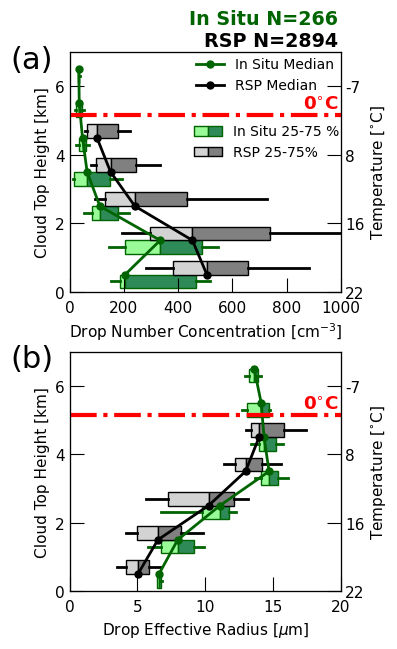

In [15]:
fig = plt.figure(figsize=(3.5,7))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)
Fontsize=11
axlist = [ax1,ax2]
#ax1.grid(lw=1,c='dimgrey',ls='dotted')
for ax in axlist:
    ax.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize,direction='in',which='both',length=10)
    ax.set_yticks([0,2,4,6])

    
#=================================
# Number concentration
#=================================
var1 = 'conc'
qn_10 = ffssp_perc_dict[var1]['10']*1.e-3
qn_90 = ffssp_perc_dict[var1]['90']*1.e-3
qn_25 = ffssp_perc_dict[var1]['25']*1.e-3
qn_med = ffssp_perc_dict[var1]['50']*1.e-3
qn_75 = ffssp_perc_dict[var1]['75']*1.e-3
qn_mean = ffssp_perc_dict[var1]['mean']*1.e-3

var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']


dark_color = 'darkgreen'
mid_color = 'seagreen'
light_color = 'palegreen'

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # Learjet
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax1.set_xlim(0,1000)
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
#ax1.plot(qn_med,height_midbins-0.2,lw=2,marker='o',c='darkgreen',label='In Situ Median',markersize=5)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
#ax1.plot(rsp_qn_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)

#=================================
# Effective Radius
#=================================
var2 = 'reff'
reff_c_10 = ffssp_perc_dict[var2]['10']
reff_c_90 = ffssp_perc_dict[var2]['90']
reff_c_25 = ffssp_perc_dict[var2]['25']
reff_c_med = ffssp_perc_dict[var2]['50']
reff_c_75 = ffssp_perc_dict[var2]['75']
reff_c_mean = ffssp_perc_dict[var2]['mean']

var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # In Situ
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax2.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax2.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    
    # Add whiskers
    ax2.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax2.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    
ax2.set_xlim(0,20)
ax2.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
#ax2.plot(reff_c_med,height_midbins-0.2,lw=2,marker='o',c='darkgreen',label='In Situ Median',markersize=5)
ax2.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
#ax2.plot(rsp_reff_c_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax2.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)


for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    #ax.set_ylim(0)
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ax1a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 3
#ax1b.plot(ctt_mean_interp,height_bins,marker='D',alpha=0.5)
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax1a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])

# Plot CTT on second subplot
ax2a = ax2.twinx()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax2a.yaxis.labelpad = 3
ax2b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.set_xticks([])
dum_yticks = ax2.get_yticks()
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax2a.set_yticklabels(dum_yticks2)
ax2a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax2.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.set_ylim(height_bins[0],height_bins[-1])

ax1.text(-0.22,1.03,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(-0.22,1.03,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

#ax1.text(1020,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax1.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax1.transAxes,ha='right',va='top')
ax2.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax2.transAxes,ha='right',va='top')
#ax2.text(30.5,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')

custom_lines = [matplotlib.lines.Line2D([0],[0],lw=3,c='dimgrey',ls='dashdot',label='0 $^{\\circ}$C')]
lgnd1 = ax1.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.02,1.03))

colors1 = ['lightgrey','grey']
edgecolor1 = 'black'
colors2 = ['palegreen','seagreen']
edgecolor2 = 'darkgreen'
patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
h = [patch2,patch1]
l = ['In Situ 25-75 %','RSP 25-75%']

lgnd2 = ax1.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(1.04,0.75),framealpha=False)

ax1.add_artist(lgnd1)

#ax1.text(0.99,1.10,'In Situ N='+str(int(len(ffssp_dict['alt']))),fontsize=Fontsize*1.25,fontweight='bold',c='darkgreen',transform=ax1.transAxes,ha='right',va='bottom')
ax1.text(0.99,1.10,'In Situ N='+str(int(ffssp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color,transform=ax1.transAxes,ha='right',va='bottom')
ax2.text(0.99,1.01,'RSP N='+str(int(rsp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c='k',transform=ax1.transAxes,ha='right',va='bottom')

plt.subplots_adjust(hspace=0.25)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_05.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()  

# Supplement Fig. 5 to include profile of LWC from the Nevzorov probe (not included in manuscript)

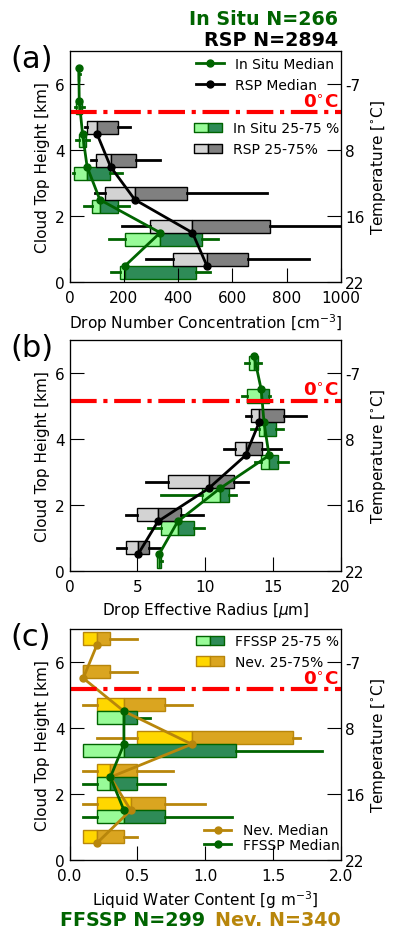

In [19]:
fig = plt.figure(figsize=(3.5,10.5))
ax1 = fig.add_subplot(311)
ax2 = fig.add_subplot(312)
ax3 = fig.add_subplot(313)
Fontsize=11
axlist = [ax1,ax2,ax3]
#ax1.grid(lw=1,c='dimgrey',ls='dotted')
for ax in axlist:
    ax.set_ylabel('Cloud Top Height [km]',fontsize=Fontsize)
    ax.tick_params(labelsize=Fontsize,direction='in',which='both',length=10)
    ax.set_yticks([0,2,4,6])

    
#=================================
# Number concentration
#=================================
var1 = 'conc'
qn_10 = ffssp_perc_dict[var1]['10']*1.e-3
qn_90 = ffssp_perc_dict[var1]['90']*1.e-3
qn_25 = ffssp_perc_dict[var1]['25']*1.e-3
qn_med = ffssp_perc_dict[var1]['50']*1.e-3
qn_75 = ffssp_perc_dict[var1]['75']*1.e-3
qn_mean = ffssp_perc_dict[var1]['mean']*1.e-3

var1='nd'
rsp_qn_10 = rsp_ct_perc_dict[var1]['10']
rsp_qn_90 = rsp_ct_perc_dict[var1]['90']
rsp_qn_25 = rsp_ct_perc_dict[var1]['25']
rsp_qn_med = rsp_ct_perc_dict[var1]['50']
rsp_qn_75 = rsp_ct_perc_dict[var1]['75']
rsp_qn_mean = rsp_ct_perc_dict[var1]['mean']


dark_color = 'darkgreen'
mid_color = 'seagreen'
light_color = 'palegreen'

for ii in range(len(height_bins)-1):
    

    #--------------------------
    # Number Concentration
    #--------------------------
    ##############
    # Learjet
    ##############
    # left box
    xx = qn_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_med[ii]-qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = qn_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = qn_75[ii]-qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))

    # Add whiskers
    ax1.plot([qn_75[ii],qn_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax1.plot([qn_10[ii],qn_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_qn_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_med[ii]-rsp_qn_25[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_qn_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_qn_75[ii]-rsp_qn_med[ii]
    yysize = 0.4
    ax1.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    # Add whiskers
    ax1.plot([rsp_qn_75[ii],rsp_qn_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax1.plot([rsp_qn_10[ii],rsp_qn_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax1.set_xlim(0,1000)
ax1.set_xlabel('Drop Number Concentration [cm$^{-3}$]',fontsize=Fontsize)
#ax1.plot(qn_med,height_midbins-0.2,lw=2,marker='o',c='darkgreen',label='In Situ Median',markersize=5)
ax1.plot(qn_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
#ax1.plot(rsp_qn_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax1.plot(rsp_qn_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)

#=================================
# Effective Radius
#=================================
var2 = 'reff'
reff_c_10 = ffssp_perc_dict[var2]['10']
reff_c_90 = ffssp_perc_dict[var2]['90']
reff_c_25 = ffssp_perc_dict[var2]['25']
reff_c_med = ffssp_perc_dict[var2]['50']
reff_c_75 = ffssp_perc_dict[var2]['75']
reff_c_mean = ffssp_perc_dict[var2]['mean']

var2 = 'Reff'
rsp_reff_c_10 = rsp_ct_perc_dict[var2]['10']
rsp_reff_c_90 = rsp_ct_perc_dict[var2]['90']
rsp_reff_c_25 = rsp_ct_perc_dict[var2]['25']
rsp_reff_c_med = rsp_ct_perc_dict[var2]['50']
rsp_reff_c_75 = rsp_ct_perc_dict[var2]['75']
rsp_reff_c_mean = rsp_ct_perc_dict[var2]['mean']

for ii in range(len(height_bins)-1):
    
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # In Situ
    ##############
    # left box
    xx = reff_c_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_med[ii]-reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = reff_c_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = reff_c_75[ii]-reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    # Add whiskers
    ax2.plot([reff_c_75[ii],reff_c_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax2.plot([reff_c_10[ii],reff_c_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    
    ##############
    # RSP
    ##############
    # left box
    xx = rsp_reff_c_25[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_med[ii]-rsp_reff_c_25[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='lightgrey'))
    # right box
    xx = rsp_reff_c_med[ii]
    yy = height_midbins[ii]
    xxsize = rsp_reff_c_75[ii]-rsp_reff_c_med[ii]
    yysize = 0.4
    ax2.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor='black',\
                           facecolor='grey'))
    
    
    # Add whiskers
    ax2.plot([rsp_reff_c_75[ii],rsp_reff_c_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')
    ax2.plot([rsp_reff_c_10[ii],rsp_reff_c_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c='black')    
    

ax2.set_xlim(0,20)
ax2.set_xlabel('Drop Effective Radius [$\\mu$m]',fontsize=Fontsize)
#ax2.plot(reff_c_med,height_midbins-0.2,lw=2,marker='o',c='darkgreen',label='In Situ Median',markersize=5)
ax2.plot(reff_c_med,height_midbins,lw=2,marker='o',c=dark_color,label='In Situ Median',markersize=5)
#ax2.plot(rsp_reff_c_med,height_midbins+0.2,lw=2,marker='o',c='black',label='RSP Median',markersize=5)
ax2.plot(rsp_reff_c_med,height_midbins,lw=2,marker='o',c='black',label='RSP Median',markersize=5)


#=================================
# LWC
#=================================
var3 = 'NevLWC'
lwc_10 = state_perc_dict[var3]['10']
lwc_90 = state_perc_dict[var3]['90']
lwc_25 = state_perc_dict[var3]['25']
lwc_med = state_perc_dict[var3]['50']
lwc_75 = state_perc_dict[var3]['75']
lwc_mean = state_perc_dict[var3]['mean']

var4 = 'FSSPWC'
ffssp_lwc_10 = state_perc_dict[var4]['10']
ffssp_lwc_90 = state_perc_dict[var4]['90']
ffssp_lwc_25 = state_perc_dict[var4]['25']
ffssp_lwc_med = state_perc_dict[var4]['50']
ffssp_lwc_75 = state_perc_dict[var4]['75']
ffssp_lwc_mean = state_perc_dict[var4]['mean']

for ii in range(len(height_bins)-1):
    light_color_nev = 'gold'
    mid_color_nev = 'goldenrod'
    dark_color_nev = 'darkgoldenrod'
    #--------------------------
    # Effective radius
    #--------------------------

    ##############
    # NevLWC
    ##############
    # left box
    xx = lwc_25[ii]
    yy = height_midbins[ii]
    xxsize = lwc_med[ii]-lwc_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color_nev,\
                           facecolor=light_color_nev))
    # right box
    xx = lwc_med[ii]
    yy = height_midbins[ii]
    xxsize = lwc_75[ii]-lwc_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color_nev,\
                           facecolor=mid_color_nev))
    # Add whiskers
    ax3.plot([lwc_75[ii],lwc_90[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c=dark_color_nev)
    ax3.plot([lwc_10[ii],lwc_25[ii]],[height_midbins[ii]+0.2,height_midbins[ii]+0.2],lw=2,c=dark_color_nev)
    
    ##############
    # FFSSP LWC
    ##############
    # left box
    xx = ffssp_lwc_25[ii]
    yy = height_midbins[ii]-0.4
    xxsize = ffssp_lwc_med[ii]-ffssp_lwc_25[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=light_color))
    # right box
    xx = ffssp_lwc_med[ii]
    yy = height_midbins[ii]-0.4
    xxsize = ffssp_lwc_75[ii]-ffssp_lwc_med[ii]
    yysize = 0.4
    ax3.add_patch(Rectangle((xx,yy),xxsize,yysize,\
                           alpha=1,edgecolor=dark_color,\
                           facecolor=mid_color))
    
    
    # Add whiskers
    ax3.plot([ffssp_lwc_75[ii],ffssp_lwc_90[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)
    ax3.plot([ffssp_lwc_10[ii],ffssp_lwc_25[ii]],[height_midbins[ii]-0.2,height_midbins[ii]-0.2],lw=2,c=dark_color)    
    

ax3.set_xlim(0,2)
ax3.set_xlabel('Liquid Water Content [g m$^{-3}$]',fontsize=Fontsize)
ax3.plot(lwc_med,height_midbins,lw=2,marker='o',c=dark_color_nev,label='Nev. Median',markersize=5)
ax3.plot(ffssp_lwc_med,height_midbins,lw=2,marker='o',c=dark_color,label='FFSSP Median',markersize=5)




for ax in axlist:
    ax.set_ylim(height_bins[0],height_bins[-1])
    #ax.set_ylim(0)
    
# Plot CTT on first subplot
ax1a = ax1.twinx()
ax1b = ax1.twiny()
ax1a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax1a.yaxis.labelpad = 3
#ax1b.plot(ctt_mean_interp,height_bins,marker='D',alpha=0.5)
ax1b.plot(rsp_qn_mean_interp,height_bins,marker='D',alpha=0.)
ax1b.set_xticks([])
dum_yticks = ax1.get_yticks()
ax1a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax1a.set_yticklabels(dum_yticks2)
ax1a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax1.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax1a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax1a.set_ylim(height_bins[0],height_bins[-1])

# Plot CTT on second subplot
ax2a = ax2.twinx()
ax2b = ax2.twiny()
ax2a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax2a.yaxis.labelpad = 3
ax2b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax2b.set_xticks([])
dum_yticks = ax2.get_yticks()
ax2a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax2a.set_yticklabels(dum_yticks2)
ax2a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax2.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax2a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax2a.set_ylim(height_bins[0],height_bins[-1])


# Plot CTT on second subplot
ax3a = ax3.twinx()
ax3b = ax3.twiny()
ax3a.set_ylabel('Temperature [$^{\\circ}$C]',fontsize=Fontsize)
ax3a.yaxis.labelpad = 3
ax3b.plot(rsp_reff_l_mean_interp,height_bins,marker='D',alpha=0.)
ax3b.set_xticks([])
dum_yticks = ax3.get_yticks()
ax3a.set_yticks(dum_yticks)
dum_yticks2 = [str(int(np.around(rsp_ctt_mean_interp[dd],0))) for dd in range(len(rsp_ctt_mean_interp))]
dum_yticks2 = dum_yticks2[::2]
ax3a.set_yticklabels(dum_yticks2)
ax3a.tick_params(labelsize=Fontsize,direction='in',which='both',length=10,pad=3)
zero_height = np.interp(0,rsp_ctt_mean_interp,height_bins)
ax3.tick_params(axis='x',pad=6)
zero_height = np.interp(0,np.flip(rsp_ctt_mean_interp),np.flip(height_bins))
ax3a.axhline(zero_height,lw=3,ls='dashdot',c='red')
ax3a.set_ylim(height_bins[0],height_bins[-1])




ax1.text(-0.22,1.03,'(a)',transform=ax1.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax2.text(-0.22,1.03,'(b)',transform=ax2.transAxes,fontsize=Fontsize*2.,va='top',ha='left')
ax3.text(-0.22,1.03,'(c)',transform=ax3.transAxes,fontsize=Fontsize*2.,va='top',ha='left')

#ax1.text(1020,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')
ax1.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax1.transAxes,ha='right',va='top')
ax2.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax2.transAxes,ha='right',va='top')
ax3.text(0.99,0.82,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold',transform=ax3.transAxes,ha='right',va='top')
#ax2.text(30.5,zero_height-0.22,'0$^{\\circ}$C',c='red',fontsize=Fontsize*1.2,fontweight='bold')

custom_lines = [matplotlib.lines.Line2D([0],[0],lw=3,c='dimgrey',ls='dashdot',label='0 $^{\\circ}$C')]
lgnd1 = ax1.legend(framealpha=False,loc='upper right',bbox_to_anchor=(1.02,1.03))

#=========================
# Top panel legend
#=========================
colors1 = ['lightgrey','grey']
edgecolor1 = 'black'
colors2 = ['palegreen','seagreen']
edgecolor2 = 'darkgreen'
patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
h = [patch2,patch1]
l = ['In Situ 25-75 %','RSP 25-75%']

lgnd2 = ax1.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(1.04,0.75),framealpha=False)

ax1.add_artist(lgnd1)

#=========================
# Bottom panel legend
#=========================
colors1 = ['palegreen','seagreen']
edgecolor1 = 'darkgreen'
colors1 = ['gold','goldenrod']
edgecolor1 = 'darkgoldenrod'
patch1 = MulticolorPatch(colors1,edgecolor1)
patch2 = MulticolorPatch(colors2,edgecolor2)
h = [patch2,patch1]
l = ['FFSSP 25-75 %','Nev. 25-75%']

lgnd3 = ax3.legend(h, l, loc='upper right', 
         handler_map={MulticolorPatch: MulticolorPatchHandler()}, 
         bbox_to_anchor=(1.04,1.03),framealpha=False)

lgnd3b = ax3.legend(framealpha=False,loc='lower right',bbox_to_anchor=(1.04,-0.02),labelspacing=0.02)

ax3.add_artist(lgnd3)


#ax1.text(0.99,1.10,'In Situ N='+str(int(len(ffssp_dict['alt']))),fontsize=Fontsize*1.25,fontweight='bold',c='darkgreen',transform=ax1.transAxes,ha='right',va='bottom')
ax1.text(0.99,1.10,'In Situ N='+str(int(ffssp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color,transform=ax1.transAxes,ha='right',va='bottom')
ax2.text(0.99,1.01,'RSP N='+str(int(rsp_samp_size)),fontsize=Fontsize*1.25,fontweight='bold',c='k',transform=ax1.transAxes,ha='right',va='bottom')

ax3.text(0.5,-0.3,'FFSSP N='+str(int(np.sum(state_samp_size_vert['FSSPWC']))),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color,transform=ax3.transAxes,ha='right',va='bottom')
ax3.text(1,-0.3,'Nev. N='+str(int(np.sum(state_samp_size_vert['NevLWC']))),fontsize=Fontsize*1.25,fontweight='bold',c=dark_color_nev,transform=ax3.transAxes,ha='right',va='bottom')

plt.subplots_adjust(hspace=0.25)

fig_path = '/discover/nobackup/mwstanfo/figures/camp2ex_paper/'
outfile = 'fig_05.png'
#plt.savefig(fig_path+outfile,dpi=300,bbox_inches='tight')
plt.show()
plt.close()  